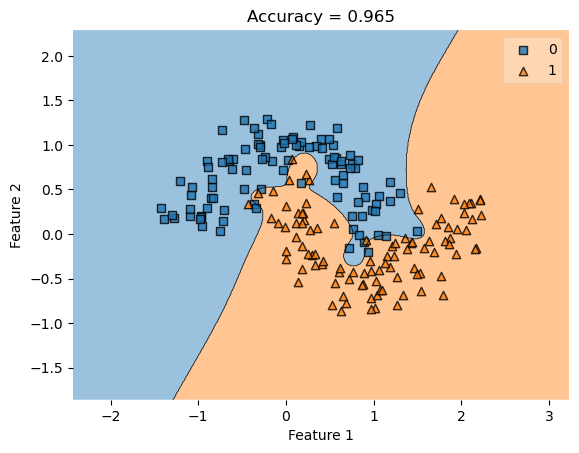

In [110]:
%reload_ext autoreload 
%autoreload 2
import numpy as np 
from kernel_logistic import KernelLogisticRegression # your source code
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import make_moons, make_circles
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt 

X, y = make_moons(200, shuffle = True, noise = 0.2)
KLR = KernelLogisticRegression(rbf_kernel, gamma = 10)
KLR.fit1(X, y)
KLR.score(X, y)

plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")


1.0


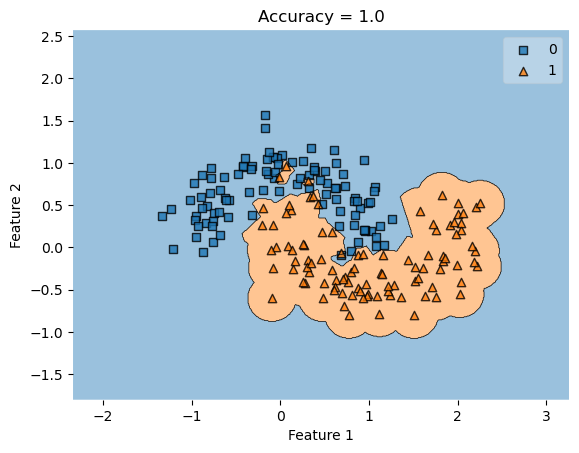

In [107]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt 

KLR = KernelLogisticRegression(rbf_kernel, gamma = 10000)
KLR.fit1(X, y)
print(KLR.score(X, y))
plot_decision_regions(X, y, clf = KLR)
title = plt.gca().set(title = f"Accuracy = {KLR.score(X, y)}",
                      xlabel = "Feature 1", 
                      ylabel = "Feature 2")

# title = plt.gca().set(title = f"Accuracy = {(KLR.predict(X) == y).mean()}",
#                       xlabel = "Feature 1", 
#                       ylabel = "Feature 2")